In [1]:
import random, os, math
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pandas as pd

In [12]:
# Analyze the aborts across the experiments
base_dir = f"../../data/pps"
aborts = {}
for scenario in os.listdir(base_dir):
    for trial in os.listdir(f"{base_dir}/{scenario}"):
        for experiment in os.listdir(f"{base_dir}/{scenario}/{trial}/Detock"):
            committed_num, aborted_num = 0, 0
            params = ""
            for client in os.listdir(f"{base_dir}/{scenario}/{trial}/Detock/{experiment}/client"):
                if os.path.isdir(f"{base_dir}/{scenario}/{trial}/Detock/{experiment}/client/{client}"):
                    summary = pd.read_csv(f"{base_dir}/{scenario}/{trial}/Detock/{experiment}/client/{client}/summary.csv")
                    metadata = pd.read_csv(f"{base_dir}/{scenario}/{trial}/Detock/{experiment}/client/{client}/metadata.csv")
                    committed_num += summary['committed'].sum()
                    aborted_num += summary['not_started'].sum()
                    mh = metadata["wl:mh"].values[0]
                    mp = metadata["wl:mp"].values[0]
                    hot = metadata["wl:hot"].values[0]
                    current = f"mh={mh}, mp={mp}, hot={hot}"
                    if params == "":
                        params = current
                    elif params != current:
                        print(f"Different parameters in the same experiment: {params} vs {current}")
            aborts[(params, scenario, trial, experiment)] = (aborted_num / committed_num * 100, committed_num, aborted_num)

# Sort decreasingly the aborts by the abort ratio
aborts = sorted(aborts.items(), key=lambda x: x[1][0], reverse=True)
print("Aborts sorted by abort ratio:")
for (params, scenario, trial, experiment), (abort_ratio, committed_num, aborted_num) in aborts:
    if int(experiment.split("-")[0]) % 2 == 0:
        continue
    print(f"Params: {params}, Scenario: {scenario}, Trial: {trial}, Experiment: {experiment}, Abort Ratio: {abort_ratio:.2f}, Committed: {committed_num}, Aborted: {aborted_num}")

Aborts sorted by abort ratio:
Params: mh=60, mp=0, hot=0.0, Scenario: baseline, Trial: trial-mp_0-1, Experiment: 7-60, Abort Ratio: 1.01, Committed: 6131475, Aborted: 61986
Params: mh=0, mp=50, hot=0.0, Scenario: baseline, Trial: trial-3, Experiment: 1-0, Abort Ratio: 1.01, Committed: 7609358, Aborted: 76795
Params: mh=20, mp=50, hot=0.0, Scenario: baseline, Trial: trial-2, Experiment: 3-20, Abort Ratio: 1.01, Committed: 7430548, Aborted: 74695
Params: mh=20, mp=50, hot=0.0, Scenario: baseline, Trial: trial-4, Experiment: 3-20, Abort Ratio: 0.99, Committed: 7510634, Aborted: 74727
Params: mh=40, mp=0, hot=0.0, Scenario: baseline, Trial: trial-mp_0-1, Experiment: 5-40, Abort Ratio: 0.99, Committed: 7474938, Aborted: 74244
Params: mh=100, mp=50, hot=0.0, Scenario: baseline, Trial: trial-3, Experiment: 11-100, Abort Ratio: 0.99, Committed: 3487810, Aborted: 34581
Params: mh=20, mp=0, hot=0.0, Scenario: baseline, Trial: trial-mp_0-1, Experiment: 3-20, Abort Ratio: 0.99, Committed: 7454927,

In [15]:
# Baseline Scenario Involved Regions and Partitions Analysis

# Variables that need to be set
trial_tags = ["trial-1", "trial-5", "trial-mp_0-1"]
samples = 10000

for i, trial_tag in enumerate(trial_tags):
    # Collecting involved regions and partitions data
    print(f"Processing {trial_tag}...")
    base_dir = f"../../data/pps/baseline/{trial_tag}/Detock"
    involved_regions = defaultdict(dict)
    involved_partitions = defaultdict(dict)
    for experiment in os.listdir(base_dir):
        mh = int(experiment.split("-")[-1])
        index = int(experiment.split("-")[0])
        involved_regions[mh][index] = {}
        involved_partitions[mh][index] = {}
        for client in os.listdir(f"{base_dir}/{experiment}/client"):
            if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
                transactions = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/transactions.csv")
                involved_regions[mh][index][client] = dict(Counter([x for x in transactions["regions"][:samples].values \
                                                 if not isinstance(x, float) or not math.isnan(x)]))
                involved_partitions[mh][index][client] = dict(Counter([x for x in transactions["partitions"][:samples].values \
                                                    if not isinstance(x, float) or not math.isnan(x)]))
    
    # Print the involved regions and partitions for each mh
    for mh in sorted(involved_regions.keys()):
        print(f"- Results for MH {mh}")
        for index in sorted(involved_regions[mh].keys()):
            current = involved_regions[mh][index]
            print(f"-- {index} Reg:", 
                  {client: {regions: f"{current[client][regions]} ({int(current[client][regions] / sum(current[client].values()) * 100)}%)" \
                    for regions in sorted(current[client])} for client in current})
            current = involved_partitions[mh][index]
            print(f"--- Partitions:", 
                  {client: {partitions: f"{current[client][partitions]} ({int(current[client][partitions] / sum(current[client].values()) * 100)}%)" \
                    for partitions in current[client]} for client in current})

Processing trial-1...
- Results for MH 0
-- 1 Reg: {'0-0': {0.0: '9455 (95%)', 1.0: '450 (4%)'}, '1-0': {0.0: '438 (4%)', 1.0: '9466 (95%)'}}
--- Partitions: {'0-0': {'1': '4167 (42%)', '0': '4266 (43%)', '0;1': '749 (7%)', '1;0': '723 (7%)'}, '1-0': {'1': '4321 (43%)', '0;1': '694 (7%)', '0': '4080 (41%)', '1;0': '809 (8%)'}}
-- 2 Reg: {'0-0': {0.0: '9458 (95%)', 1.0: '423 (4%)'}, '1-0': {0.0: '429 (4%)', 1.0: '9456 (95%)'}}
--- Partitions: {'0-0': {'0;1': '925 (9%)', '0': '4170 (42%)', '1': '4225 (42%)', '1;0': '561 (5%)'}, '1-0': {'1': '4225 (42%)', '0': '4158 (42%)', '1;0': '889 (8%)', '0;1': '613 (6%)'}}
- Results for MH 20
-- 3 Reg: {'0-0': {'0': '8330 (83%)', '0;1': '613 (6%)', '1': '1017 (10%)'}, '1-0': {'0': '1001 (10%)', '0;1': '564 (5%)', '1': '8330 (84%)'}}
--- Partitions: {'0-0': {'0': '4156 (41%)', '1': '4234 (42%)', '0;1': '924 (9%)', '1;0': '646 (6%)'}, '1-0': {'0': '4275 (43%)', '1': '4180 (42%)', '1;0': '769 (7%)', '0;1': '671 (6%)'}}
-- 4 Reg: {'0-0': {'0': '8288 (83

In [9]:
# Baseline Scenario Record Access Analysis

# Variables that need to be set
trial_tag = "trial-5"
samples = 10000

base_dir = f"../../data/pps/baseline/{trial_tag}/Detock"
experiments = os.listdir(base_dir)
experiments = sorted(experiments, key=lambda x: int(x.split("-")[-1]))

record_access = {}
for i, experiment in enumerate(experiments):
    print(f"Processing {experiment}...")
    # Collecting transaction codes
    codes = {}
    for client in os.listdir(f"{base_dir}/{experiment}/client"):
        if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
            transactions = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/transactions.csv")
            codes[client] = transactions["code"].tolist()[:samples]

    # Collecting product access data for get_parts_by_product
    gpbp_type = {}
    for client in codes.keys():
        gpbp_type[client] = []
        for code in codes[client]:
            type = code.split(";")[0]
            if type == "get_parts_by_product":
                gpbp_type[client].append(int(code.split(";")[1]))
    record_access[experiment] = gpbp_type

Processing 1-0...
Processing 2-0...
Processing 3-20...
Processing 4-20...
Processing 6-40...
Processing 5-40...
Processing 8-60...
Processing 7-60...
Processing 10-80...
Processing 9-80...
Processing 12-100...
Processing 11-100...


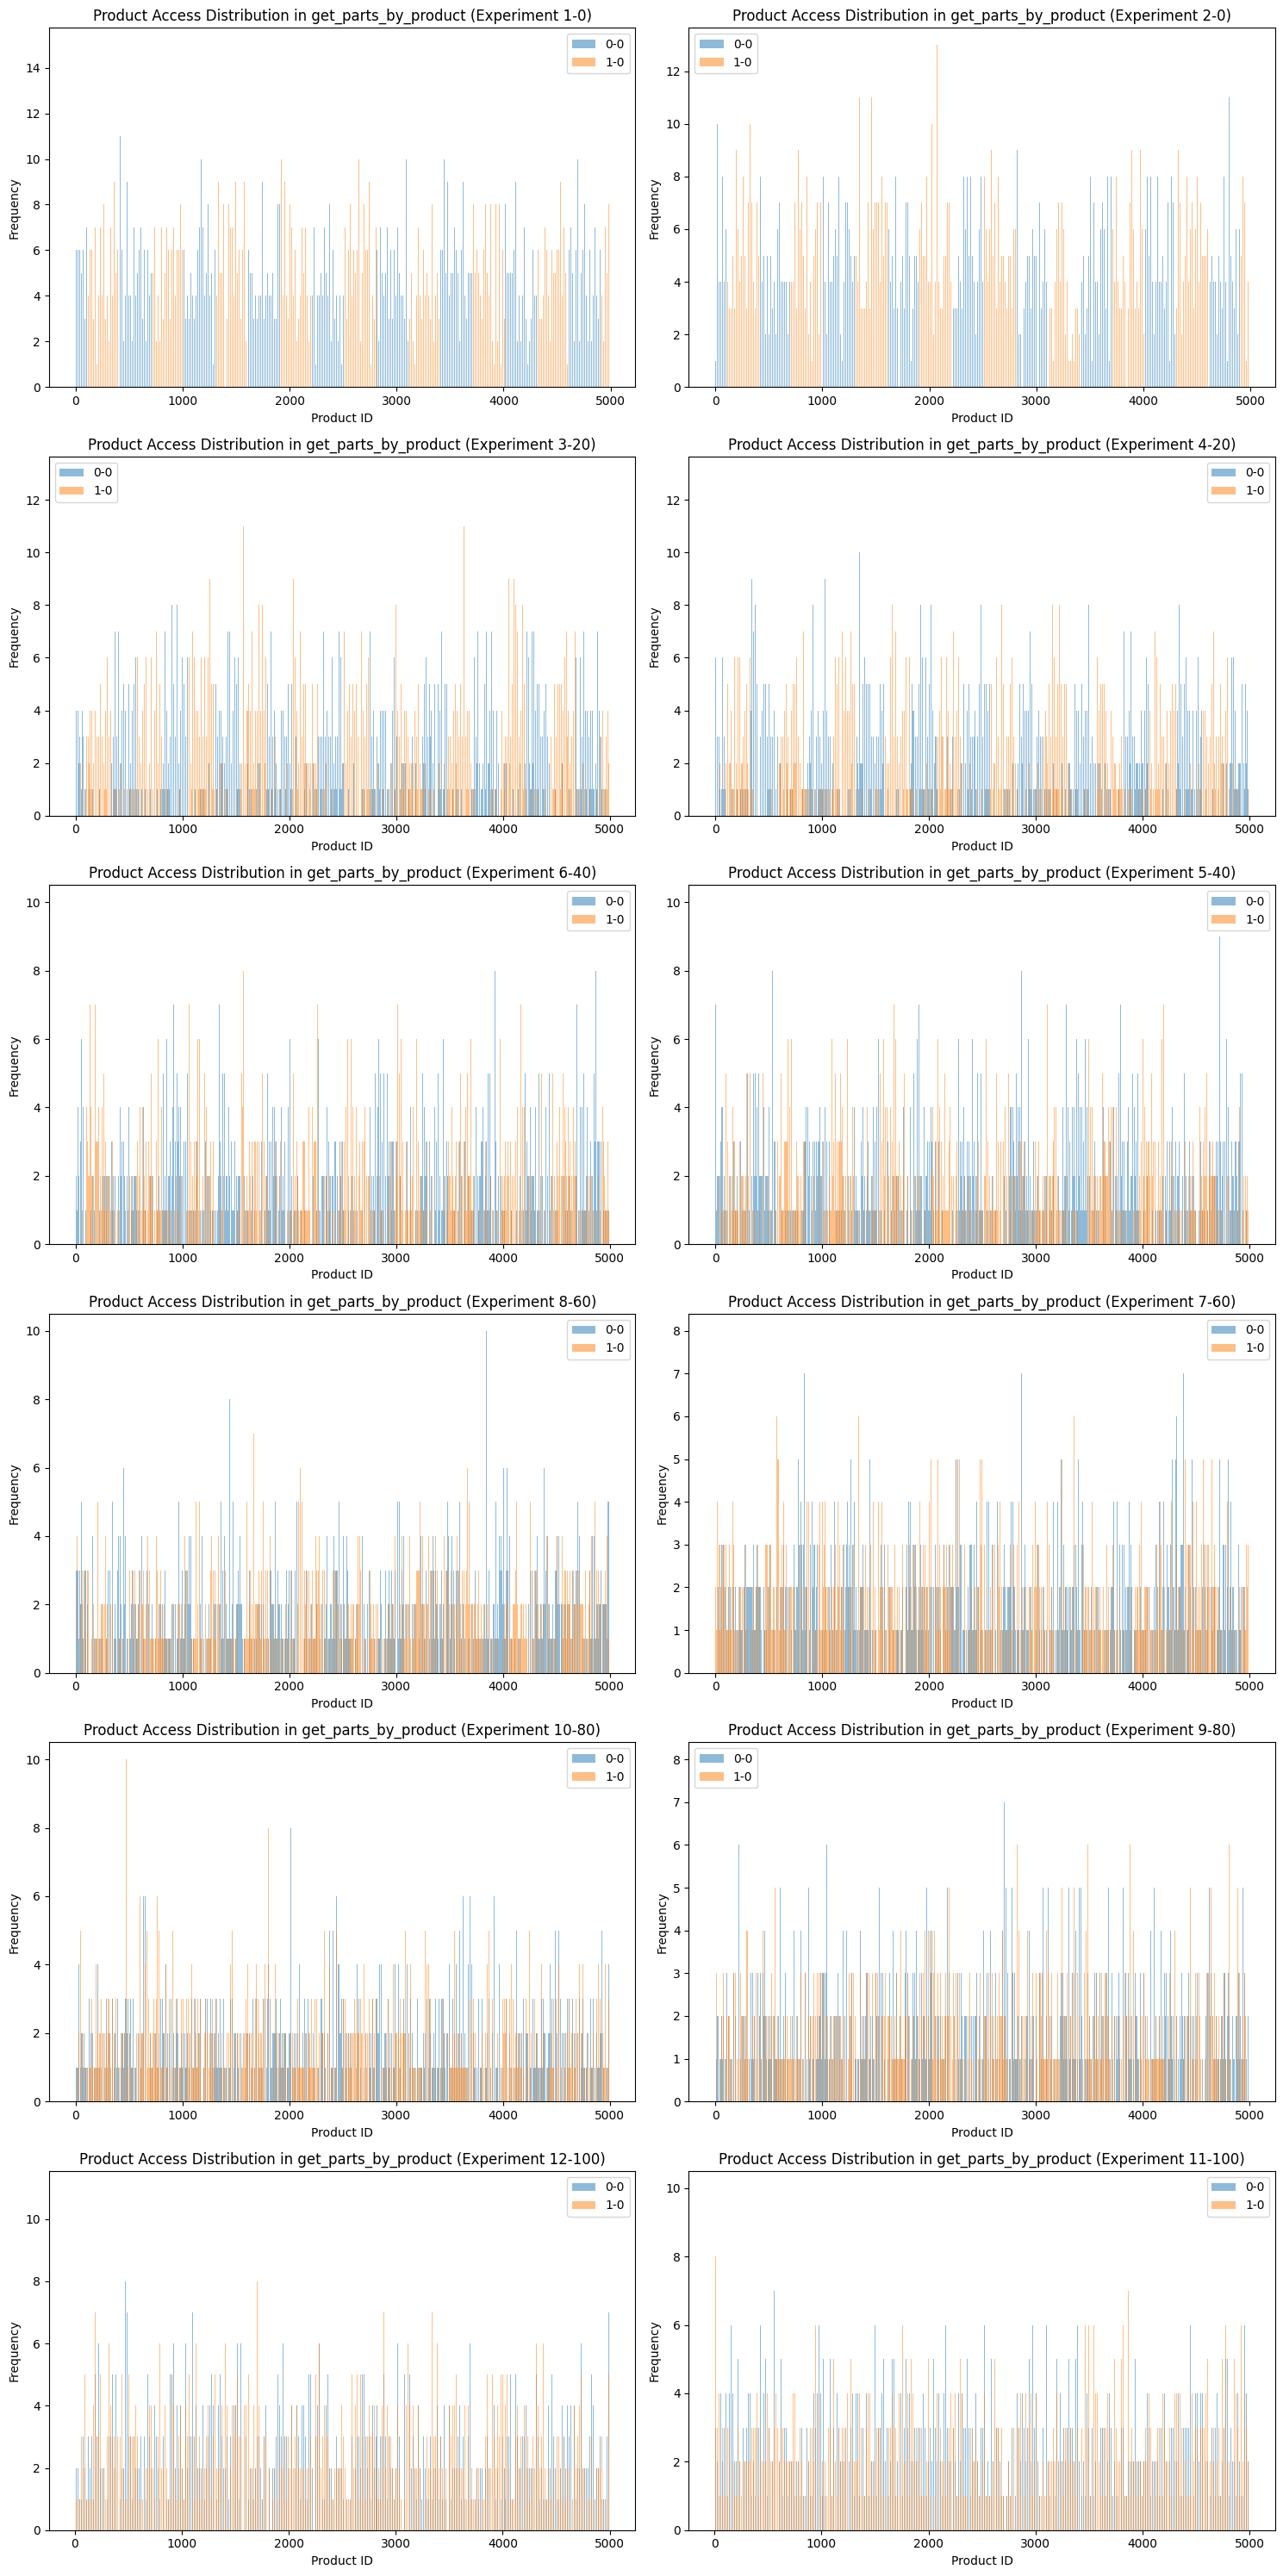

In [10]:
# Variables that need to be set
cols = 2

rows = int(np.ceil(len(experiments) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  

# Plot the product access distribution for each experiment for get_parts_by_product
for i, experiment in enumerate(experiments):
    gpbp_type = record_access[experiment]
    for j, client in enumerate(gpbp_type.keys()):
        mn = min(gpbp_type[client])
        mx = max(gpbp_type[client])
        axes[i].hist(gpbp_type[client], bins=range(mn, mx + 1), alpha=0.5, label=client)
    axes[i].set_title(f"Product Access Distribution in get_parts_by_product (Experiment {experiment})")
    axes[i].set_xlabel("Product ID")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()
plt.tight_layout()
plt.show()

In [12]:
print(len(set(record_access["12-100"]["0-0"]).intersection(set(record_access["12-100"]["1-0"]))))

2066
